In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/time-series/household_power_consumption_1.csv
/kaggle/input/time-series/household_power_consumption.csv
/kaggle/input/time-series/household_power_consumption_days.csv
/kaggle/input/time-series/household_power_consumption/household_power_consumption.txt


In [3]:
pip install --upgrade tensorflow-io

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.0/28.0 MB 37.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 63.6 MB/s eta 0:00:00:00:01
  Attempting uninstall: tensorflow-io-gcs-filesystem
    Found existing installation: tensorflow-io-gcs-filesystem 0.31.0
    Uninstalling tensorflow-io-gcs-filesystem-0.31.0:
      Successfully uninstalled tensorflow-io-gcs-filesystem-0.31.0
  Attempting uninstall: tensorflow-io
    Found existing installation: tensorflow-io 0.31.0
    Uninstalling tensorflow-io-0.31.0:
      Successfully uninstalled tensorflow-io-0.31.0
Note: you may need to restart the kernel to use updated packages.


### Uni-Variate CNN Model

cnn: [373.254] 389.4, 376.7, 340.2, 350.1, 368.9, 320.8, 452.2


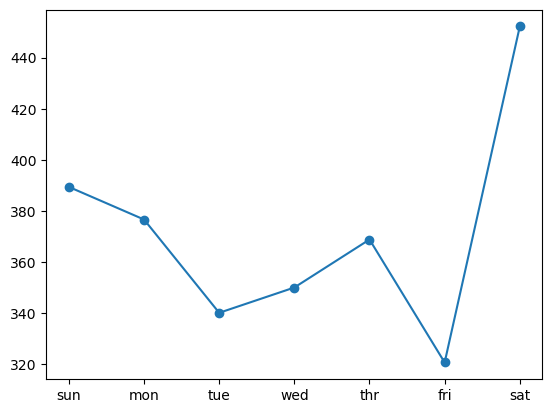

In [37]:
# univariate multi-step cnn for the power usage dataset
from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

# split a univariate dataset into train/test sets
def split_dataset(data):
    # split into standard weeks
    train, test = data[1:-328], data[-328:-6]
    # restructure into windows of weekly data
    train = array(split(train, len(train)/7))
    test = array(split(test, len(test)/7))
    return train, test

# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
    scores = list()
    # calculate an RMSE score for each day
    for i in range(actual.shape[1]):
        # calculate mse
        mse = mean_squared_error(actual[:, i], predicted[:, i])
        # calculate rmse
        rmse = sqrt(mse)
        # store
        scores.append(rmse)
        # calculate overall RMSE
    s = 0
    for row in range(actual.shape[0]):
        for col in range(actual.shape[1]):
            s += (actual[row, col] - predicted[row, col])**2
    score = sqrt(s / (actual.shape[0] * actual.shape[1]))
    return score, scores

# summarize scores
def summarize_scores(name, score, scores):
    s_scores = ', '.join(['%.1f' % s for s in scores])
    print('%s: [%.3f] %s' % (name, score, s_scores))

# convert history into inputs and outputs
def to_supervised(train, n_input, n_out=7):
    # flatten data
    data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
    X, y = list(), list()
    in_start = 0
    # step over the entire history one time step at a time
    for _ in range(len(data)):
        # define the end of the input sequence
        in_end = in_start + n_input
        out_end = in_end + n_out
        # ensure we have enough data for this instance
        if out_end <= len(data):
            x_input = data[in_start:in_end, 0]
            x_input = x_input.reshape((len(x_input), 1))
            X.append(x_input)
            y.append(data[in_end:out_end, 0])
            # move along one time step
        in_start += 1
    return array(X), array(y)

# train the model
def build_model(train, n_input):
    # prepare data
    train_x, train_y = to_supervised(train, n_input)
    # define parameters
    verbose, epochs, batch_size = 0, 80, 4
    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
    # define model
    model = Sequential()
    model.add(Conv1D(16, 3, activation='relu', input_shape=(n_timesteps,n_features)))
    model.add(MaxPooling1D())
    model.add(Flatten())
    model.add(Dense(10, activation='relu'))
    model.add(Dense(n_outputs))
    model.compile(loss='mse', optimizer='adam')
    # fit network
    model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
    return model

# make a forecast
def forecast(model, history, n_input):
    # flatten data
    data = array(history)
    data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
    # retrieve last observations for input data
    input_x = data[-n_input:, 0]
    # reshape into [1, n_input, 1]
    input_x = input_x.reshape((1, len(input_x), 1))
    # forecast the next week
    yhat = model.predict(input_x, verbose=0)
    # we only want the vector forecast
    yhat = yhat[0]
    return yhat

# evaluate a single model
def evaluate_model(train, test, n_input):
    # fit model
    model = build_model(train, n_input)
    # history is a list of weekly data
    history = [x for x in train]
    # walk-forward validation over each week
    predictions = list()
    for i in range(len(test)):
        # predict the week
        yhat_sequence = forecast(model, history, n_input)
        # store the predictions
        predictions.append(yhat_sequence)
        # get real observation and add to history for predicting the next week
        history.append(test[i, :])
    # evaluate predictions days for each week
    predictions = array(predictions)
    score, scores = evaluate_forecasts(test[:, :, 0], predictions)
    return score, scores

# load the new file
dataset = read_csv('/kaggle/input/time-series/household_power_consumption_days.csv', header=0,
                                       infer_datetime_format=True, parse_dates=['datetime'], index_col=['datetime'])
# split into train and test
train, test = split_dataset(dataset.values)
# evaluate model and get scores
n_input = 56
score, scores = evaluate_model(train, test, n_input)
# summarize scores
summarize_scores('cnn', score, scores)
# plot scores
days = ['sun', 'mon', 'tue', 'wed', 'thr', 'fri', 'sat']
pyplot.plot(days, scores, marker='o', label='cnn')
pyplot.show()

### Multi-Channel CNN

cnn: [391.625] 413.1, 399.2, 351.2, 396.6, 372.7, 327.9, 465.3


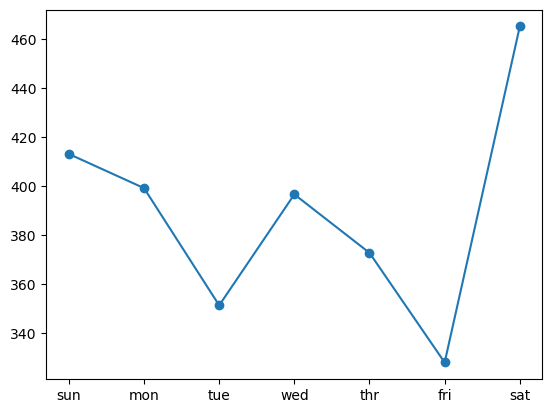

In [46]:
# multichannel multi-step cnn for the power usage dataset
from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

# split a univariate dataset into train/test sets
def split_dataset(data):
    # split into standard weeks
    train, test = data[1:-328], data[-328:-6]
    # restructure into windows of weekly data
    train = array(split(train, len(train)/7))
    test = array(split(test, len(test)/7))
    return train, test

# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
    scores = list()
    # calculate an RMSE score for each day
    for i in range(actual.shape[1]):
        # calculate mse
        mse = mean_squared_error(actual[:, i], predicted[:, i])
        # calculate rmse
        rmse = sqrt(mse)
        # store
        scores.append(rmse)
    # calculate overall RMSE
    s = 0
    for row in range(actual.shape[0]):
        for col in range(actual.shape[1]):
            s += (actual[row, col] - predicted[row, col])**2
    score = sqrt(s / (actual.shape[0] * actual.shape[1]))
    return score, scores

# summarize scores
def summarize_scores(name, score, scores):
    s_scores = ', '.join(['%.1f' % s for s in scores])
    print('%s: [%.3f] %s' % (name, score, s_scores))

# convert history into inputs and outputs
def to_supervised(train, n_input, n_out=7):
    # flatten data
    data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
    X, y = list(), list()
    in_start = 0
    # step over the entire history one time step at a time
    for _ in range(len(data)):
        # define the end of the input sequence
        in_end = in_start + n_input
        out_end = in_end + n_out
        # ensure we have enough data for this instance
        if out_end <= len(data):
            X.append(data[in_start:in_end, :])
            y.append(data[in_end:out_end, 0])
        # move along one time step
        in_start += 1
    return array(X), array(y)

# train the model
def build_model(train, n_input):
    # prepare data
    train_x, train_y = to_supervised(train, n_input)
    # define parameters
    verbose, epochs, batch_size = 0,100, 16
    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
    # define model
    model = Sequential()
    model.add(Conv1D(32, 3, activation='relu', input_shape=(n_timesteps,n_features)))
    model.add(Conv1D(32, 3, activation='relu'))
    model.add(MaxPooling1D())
    model.add(Conv1D(16, 3, activation='relu'))
    model.add(MaxPooling1D())
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_outputs))
    model.compile(loss='mse', optimizer='adam')
    # fit network
    model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
    return model

# make a forecast
def forecast(model, history, n_input):
    # flatten data
    data = array(history)
    data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
    # retrieve last observations for input data
    input_x = data[-n_input:, :]
    # reshape into [1, n_input, n]
    input_x = input_x.reshape((1, input_x.shape[0], input_x.shape[1]))
    # forecast the next week
    yhat = model.predict(input_x, verbose=0)
    # we only want the vector forecast
    yhat = yhat[0]
    return yhat

# evaluate a single model
def evaluate_model(train, test, n_input):
    # fit model
    model = build_model(train, n_input)
    # history is a list of weekly data
    history = [x for x in train]
    # walk-forward validation over each week
    predictions = list()
    for i in range(len(test)):
        # predict the week
        yhat_sequence = forecast(model, history, n_input)
        # store the predictions
        predictions.append(yhat_sequence)
        # get real observation and add to history for predicting the next week
        history.append(test[i, :])
    # evaluate predictions days for each week
    predictions = array(predictions)
    score, scores = evaluate_forecasts(test[:, :, 0], predictions)
    return score, scores

# load the new file
dataset = read_csv('/kaggle/input/time-series/household_power_consumption_days.csv', header=0,
                            infer_datetime_format=True, parse_dates=['datetime'], index_col=['datetime'])
# split into train and test
train, test = split_dataset(dataset.values)
# evaluate model and get scores
n_input = 28
score, scores = evaluate_model(train, test, n_input)
# summarize scores
summarize_scores('cnn', score, scores)
# plot scores
days = ['sun', 'mon', 'tue', 'wed', 'thr', 'fri', 'sat']
pyplot.plot(days, scores, marker='o', label='cnn')
pyplot.show()

## Multi-Headed CNN

cnn: [432.084] 452.4, 499.7, 388.2, 400.7, 409.3, 336.7, 510.2


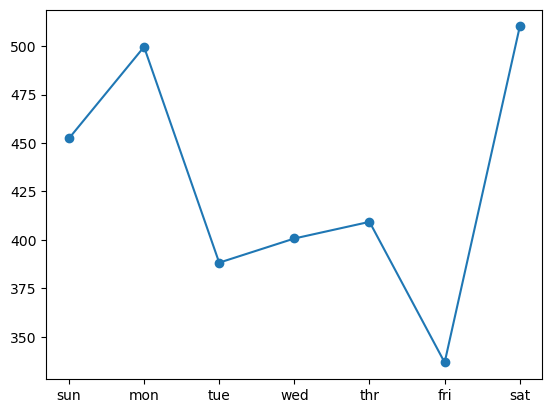

In [54]:
# multi headed multi-step cnn for the power usage dataset
from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from keras.utils.vis_utils import plot_model
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.models import Model
from keras.layers import Input
# from keras.layers.merge import concatenate
from tensorflow.keras.layers import concatenate

# split a univariate dataset into train/test sets
def split_dataset(data):
    # split into standard weeks
    train, test = data[1:-328], data[-328:-6]
    # restructure into windows of weekly data
    train = array(split(train, len(train)/7))
    test = array(split(test, len(test)/7))
    return train, test

def evaluate_forecasts(actual, predicted):
    scores = list()
    # calculate an RMSE score for each day
    for i in range(actual.shape[1]):
        # calculate mse
        mse = mean_squared_error(actual[:, i], predicted[:, i])
        # calculate rmse
        rmse = sqrt(mse)
        # store
        scores.append(rmse)
    # calculate overall RMSE
    s = 0
    for row in range(actual.shape[0]):
        for col in range(actual.shape[1]):
            s += (actual[row, col] - predicted[row, col])**2
    score = sqrt(s / (actual.shape[0] * actual.shape[1]))
    return score, scores

# summarize scores
def summarize_scores(name, score, scores):
    s_scores = ', '.join(['%.1f' % s for s in scores])
    print('%s: [%.3f] %s' % (name, score, s_scores))

# convert history into inputs and outputs
def to_supervised(train, n_input, n_out=7):
    # flatten data
    data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
    X, y = list(), list()
    in_start = 0
    # step over the entire history one time step at a time
    for _ in range(len(data)):
        # define the end of the input sequence
        in_end = in_start + n_input
        out_end = in_end + n_out
        # ensure we have enough data for this instance
        if out_end <= len(data):
            X.append(data[in_start:in_end, :])
            y.append(data[in_end:out_end, 0])
        # move along one time step
        in_start += 1
    return array(X), array(y)

# plot training history
def plot_history(history):
    # plot loss
    pyplot.subplot(2, 1, 1)
    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'], label='test')
    pyplot.title('loss', y=0, loc='center')
    pyplot.legend()
    # plot rmse
    pyplot.subplot(2, 1, 2)
    pyplot.plot(history.history['rmse'], label='train')
    pyplot.plot(history.history['val_rmse'], label='test')
    pyplot.title('rmse', y=0, loc='center')
    pyplot.legend()
    pyplot.show()

# train the model
def build_model(train, n_input):
    # prepare data
    train_x, train_y = to_supervised(train, n_input)
    # define parameters
    verbose, epochs, batch_size = 0, 50, 16
    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
    # create a channel for each variable
    in_layers, out_layers = list(), list()
    for _ in range(n_features):
        inputs = Input(shape=(n_timesteps,1))
        conv1 = Conv1D(32, 3, activation='relu')(inputs)
        conv2 = Conv1D(32, 3, activation='relu')(conv1)
        pool1 = MaxPooling1D()(conv2)
        flat = Flatten()(pool1)
        # store layers
        in_layers.append(inputs)
        out_layers.append(flat)
    # merge heads
    merged = concatenate(out_layers)
    # interpretation
    dense1 = Dense(200, activation='relu')(merged)
    dense2 = Dense(100, activation='relu')(dense1)
    outputs = Dense(n_outputs)(dense2)
    model = Model(inputs=in_layers, outputs=outputs)
    # compile model
    model.compile(loss='mse', optimizer='adam')
    # plot the model
    plot_model(model, show_shapes=True, to_file='multiheaded_cnn.png')
    # fit network
    input_data = [train_x[:,:,i].reshape((train_x.shape[0],n_timesteps,1)) for i in
                                                                               range(n_features)]
    model.fit(input_data, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
    return model

# make a forecast
def forecast(model, history, n_input):
    # flatten data
    data = array(history)
    data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
    # retrieve last observations for input data
    input_x = data[-n_input:, :]
    # reshape into n input arrays
    input_x = [input_x[:,i].reshape((1,input_x.shape[0],1)) for i in range(input_x.shape[1])]
    # forecast the next week
    yhat = model.predict(input_x, verbose=0)
    # we only want the vector forecast
    yhat = yhat[0]
    return yhat

# evaluate a single model
def evaluate_model(train, test, n_input):
    # fit model
    model = build_model(train, n_input)
    # history is a list of weekly data
    history = [x for x in train]
    # walk-forward validation over each week
    predictions = list()
    for i in range(len(test)):
        # predict the week
        yhat_sequence = forecast(model, history, n_input)
        # store the predictions
        predictions.append(yhat_sequence)
        # get real observation and add to history for predicting the next week
        history.append(test[i, :])
    # evaluate predictions days for each week
    predictions = array(predictions)
    score, scores = evaluate_forecasts(test[:, :, 0], predictions)
    return score, scores

# load the new file
dataset = read_csv('/kaggle/input/time-series/household_power_consumption_days.csv', header=0,
                                        infer_datetime_format=True, parse_dates=['datetime'], index_col=['datetime'])
# split into train and test
train, test = split_dataset(dataset.values)
# evaluate model and get scores
n_input = 14
score, scores = evaluate_model(train, test, n_input)
# summarize scores
summarize_scores('cnn', score, scores)
# plot scores
days = ['sun', 'mon', 'tue', 'wed', 'thr', 'fri', 'sat']
pyplot.plot(days, scores, marker='o', label='cnn')
pyplot.show()